In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [43]:
class consts:
    pi = 3.141592

class setup:
    dummy = 0

In [44]:
data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(0,1), header=(0))
data

,tp,v
0,947.0,36.42
1,937.0,36.36
2,939.0,36.34
3,939.0,36.30
4,938.0,36.30
5,938.0,36.30
6,938.0,36.29
7,937.0,36.26
8,939.0,36.26
9,938.0,36.26


## Опробование работы

In [45]:
data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(0,1), header=(0)).dropna()
data

termo_coeff = (47000-29000)/(1168-716)
print(termo_coeff)
t_out = 22
t_termo = 1e3 * data['v'] / termo_coeff + t_out

t_termo_error = np.std(t_termo) / math.sqrt(t_termo.size)


t_termo.mean()
data['tp'].mean()

export = pd.concat([
    data['tp'],
    data['v'],
    t_termo.rename('tr'),  
], axis=1)


fmt = {
    'tp' : [r'$T_{p}, ^oC$', '{:.1f}', 0],
    'v' : [r'$V$, мВ', '{:.1f}', 0],
    'tr' : [r'$T_{t}, ^oC$', '{:.1f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-try.tex')

print("$$T_t = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(t_termo.mean(), 5))
print("$$T_p = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(data['tp'].mean(), 12))


39.823008849557525
$$T_t = (934 \pm 5) \;\;^oC$$

$$T_p = (939 \pm 12) \;\;^oC$$



In [46]:
v_error = np.std(data['v']) / math.sqrt(data['v'].size) + 0.005
#v_error / data['v'].mean() * t_termo.mean()
v_error / data['v'].mean() * t_termo.mean()



0.5244100871534852

In [47]:
t_termo_error

0.38649907606936607

## Стефан-Больцман

In [48]:
from scipy.interpolate import interp1d

data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(2,3,4,5), header=(0)).dropna()
data

At = 1.09
At_error = 0.03
Bt = -15
Bt_error = 20

print('$$ f_1(T) = ({} \pm {}) \cdot T + ({} \pm {})$$'.format(At, At_error, Bt, Bt_error))

def br2real(x):
    return At * x + Bt

T = br2real(data['Tp'] + 273)
W = data['I'] * data['V']

$$ f_1(T) = (1.09 \pm 0.03) \cdot T + (-15 \pm 20)$$


0    1059.24
1    1210.75
2    1161.70
3    1315.39
4    1413.49
5    1561.73
6    1705.61
7    1917.07
8    2077.30
Name: Tp, dtype: float64


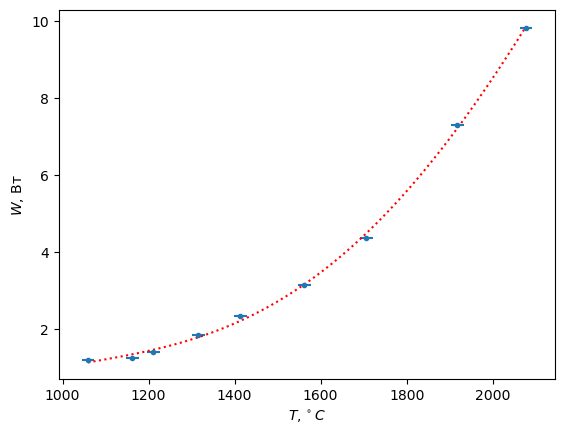

In [49]:
def interp(x, y):
    return interp1d(x, y, kind='cubic')
T = T - 273

mipt.plot(T, W, func=None, marker_size=6, exclude=[], linestyle='dashed', xerr=15)

z = np.polyfit(T, W, 4)
p = np.poly1d(z)
t = np.linspace(T.min(), T.max(), 100)
plt.plot(t, p(t), ms=10, linestyle=':', color="red")


plt.ylabel(r"$W$, Вт")
plt.xlabel(r"$T, ^\circ C$")
# plt.legend()
plt.savefig('gen/fig-wt.pdf')
print(T)
T = T + 273



In [50]:

export = pd.concat([
    data['Tp'],
    data['I'],
    data['V'],
    W.rename('W'),  
], axis=1)


fmt = {
    'Tp' : [r'$T, ^oC$', '{:.1f}', 0],
    'I' : [r'$I$, А', '{:.2f}', 0],
    'V' : [r'$V$, В', '{:.2f}', 0],
    'W' : [r'$W$, Вт', '{:.2f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-sb.tex')
tab.rename().data

,"$T, ^oC$","$I$, А","$V$, В","$W$, Вт"
0,963.0,0.563,2.115,1.190745
1,1102.0,0.590,2.389,1.409510
2,1057.0,0.571,2.194,1.252774
3,1198.0,0.638,2.881,1.838078
4,1288.0,0.686,3.402,2.333772
5,1424.0,0.752,4.166,3.132832
6,1556.0,0.837,5.218,4.367466
7,1750.0,0.992,7.357,7.298144
8,1897.0,1.098,8.950,9.827100


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,7.491339,0.028434,1.114212,0.496923,0.118679,4.173774,0.096385,-30.152944,0.722238


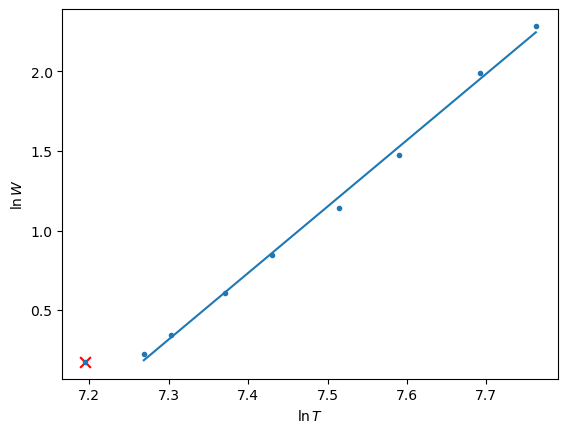

In [51]:
x, y, equ = mipt.plot(np.log(T), np.log(W), exclude=[0], yerr = 0)

mnk = mipt.mnk(x, y)
mnk.to_latex('gen/tab-mnk.tex')

plt.ylabel(r"$\ln W$")
plt.xlabel(r"$\ln T$")
plt.savefig('gen/fig-linwt.pdf')

mnk.data

$$ \varepsion_T = -0.08 \cdot T^2 + 0.0002 \cdot T + -1.6e-08 $$


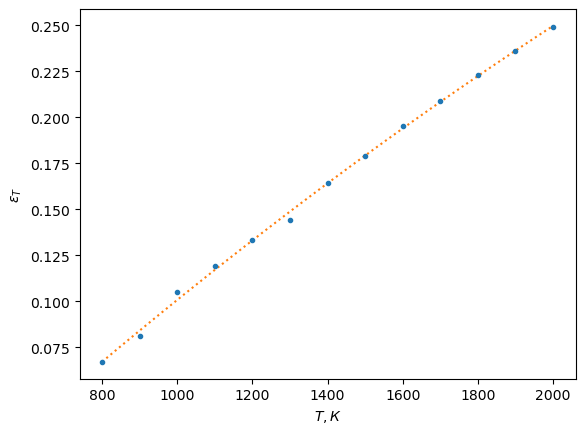

In [52]:
data_eps = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(5,6), header=(0)).dropna()

x, y, equ = mipt.plot(data_eps['Teps'], data_eps['Eps'], exclude=[], func=None)

mnk = mipt.mnk(x, y)


z = np.polyfit(data_eps['Teps'], data_eps['Eps'], 2)
epsilon = np.poly1d(z)
t = np.linspace(data_eps['Teps'].min(), data_eps['Teps'].max(), 100)
plt.plot(t, epsilon(t), ms=10, linestyle=':')

plt.xlabel(r"$T, К$")
plt.ylabel(r"$\varepsilon_T$")
plt.savefig('gen/fig-epsilon.pdf')


epsilon
print('$$ \\varepsion_T = {:.2g} \\cdot T^2 + {:.2g} \\cdot T + {:.2g} $$'.format(epsilon[0], epsilon[1], epsilon[2]))

0    6.831220e-08
1    4.571552e-08
2    4.850213e-08
3    4.173983e-08
4    3.883557e-08
5    3.380456e-08
6    3.208192e-08
7    3.212958e-08
8    3.041018e-08
dtype: float64


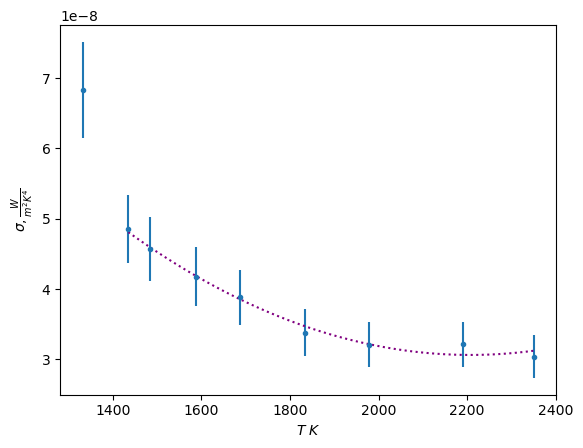

In [53]:
S = 0.36e-4
sigmas = W / (epsilon(T) * T**4 * S)
print(sigmas)

def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=True)

x, y, equ = mipt.plot(T, sigmas, exclude=[], func=None, linestyle='--', yerr=sigmas*0.10)


z = np.polyfit(T[1:], sigmas[1:], 2)
ff = np.poly1d(z)
t = np.linspace(T[1:].min(), T.max(), 100)

plt.plot(t, ff(t), ms=10, linestyle=':', c ='purple')

plt.xlabel(r"$T \;K$")
plt.ylabel(r"$\sigma, \frac{W}{m^2 K^4}$")
plt.savefig('gen/fig-sigma.pdf')

In [54]:
sigma = sigmas[5:].mean()

h = ((2 * 3.141592**5 * (1.380e-23)**4)/(15 * (3e8)**2 * sigma))**(1/3)
h

h*0.1

8.000600286182812e-35

### Построение графика lnW от lnT при известной E_t

        <x>        sx        <y>        sy       rxy         a        da  \
0  7.491339  0.028434  12.863124  0.267187  0.086815  3.053154  0.111687   

           b        db  
0 -10.009089  0.836898  


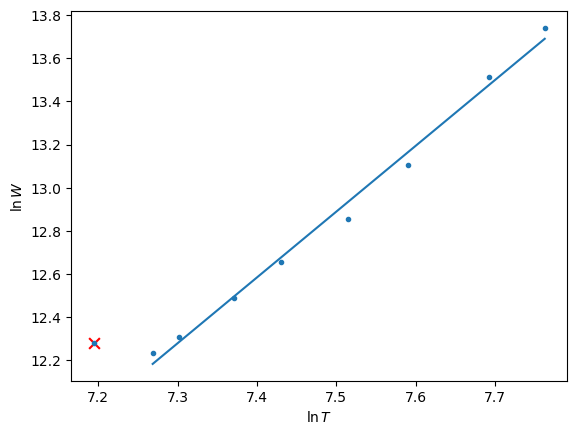

In [55]:
# lnW - ln(E_t S) = ln(sigma) + n ln(T)
corr = np.log(epsilon(T) * S)
lnW = np.log(W) - corr
lnT = np.log(T)
x, y, equ = mipt.plot(lnT, lnW, exclude=[0], yerr = 0)

mnk = mipt.mnk(x, y)
print(mnk.data)
#mnk.to_latex('gen/tab-mnk.tex')

plt.ylabel(r"$\ln W$")
plt.xlabel(r"$\ln T$")
plt.savefig('gen/test.pdf')